In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
import datetime
import time
from math import ceil

#add comment
"""
Hyperparameters for training and dataset initialization
"""
IMAGE_SIZE = [125, 135]
BATCH_SIZE = 64
training_percentage = 0.8

In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#Checking which device the code is running on

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3753636416955515919
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13770826384877977521
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2563655450892838050
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11146783616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4329387598687780113
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [23]:
"""
Utility functions used for data processing
"""
def resize(image):
    # option 1: first normalize the image to (-1,1)

    # option 2: standardization
    image = tf.image.per_image_standardization(image)
    # resize to 125, 135 (preserving the aspect ration) with 0-padding
    image = tf.image.resize_with_pad(image,
                                     IMAGE_SIZE[0],
                                     IMAGE_SIZE[1],
                                     method=tf.image.ResizeMethod.BILINEAR,
                                     antialias=False
                                     )
    return image

def show_images(dataset, n):
  for image, label in dataset.take(n):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(str(label))
    plt.axis("off")
    plt.show()

In [24]:

#Loading dataset and resizing the images before allocating them to training and testing datasets.

malaria_ds = tfds.load('malaria', split='train', shuffle_files=True, as_supervised=True, download=True, with_info=False)
malaria_ds = malaria_ds.map(lambda image, label: (resize(image), tf.one_hot(label, 2)))
ds_size = 27558 #as given by the dataset documentation

#Split dataset between training and testing(validation)
train_ds = malaria_ds.take(int(ds_size * training_percentage))
val_ds = malaria_ds.skip(int(ds_size * training_percentage))

train_ds=(train_ds.cache().batch(BATCH_SIZE))
val_ds= (val_ds.cache().batch(BATCH_SIZE))

#randomly flip some images (disabled cause it didn't significantly improve accuracy despite the additional time cost)
if 1==0:
  print("Flipping images randomly")
  count = 0
  for image, label in malaria_ds:
    tf.image.random_flip_left_right(image, seed=None)
    tf.image.random_flip_up_down(image, seed=None)
    count+=1
    if (count%int((ds_size/10))==0):
      percentage = count/ds_size
      progstring = "Progress: " + str(ceil(percentage*100)) + "%"
      print(progstring)
  print("Image flipping complete.")

def conv_block(filters):
  block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ]
  )

  return block

def dense_block(units, dropout_rate):
  block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

  return block
  
def build_model():
  model = tf.keras.Sequential([
      tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
      conv_block(64),
      conv_block(16),
      conv_block(32),
      tf.keras.layers.Flatten(),
      dense_block(32, 0.2),
      dense_block(32, 0.2),
      tf.keras.layers.Dense(2,activation='softmax')
  ])

  return model


#Training starts here

model = build_model()
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=tf.keras.metrics.BinaryAccuracy(name='BinAccuracy') #used because label is either 0 or 1
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


history = model.fit(
    train_ds, epochs=10, validation_data=val_ds
)

model.evaluate(val_ds)

Epoch 1/10
  2/345 [..............................] - ETA: 1:54 - loss: 1.1552 - BinAccuracy: 0.5078WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1556s vs `on_train_batch_end` time: 0.4201s). Check your callbacks.


345/345 [==============================] - 241s 700ms/step - loss: 0.3940 - BinAccuracy: 0.8284 - val_loss: 1.9858 - val_BinAccuracy: 0.5000
Epoch 2/10
345/345 [==============================] - 182s 529ms/step - loss: 0.1983 - BinAccuracy: 0.9304 - val_loss: 0.1967 - val_BinAccuracy: 0.9331
Epoch 3/10
345/345 [==============================] - 183s 530ms/step - loss: 0.1676 - BinAccuracy: 0.9412 - val_loss: 0.1902 - val_BinAccuracy: 0.9351
Epoch 4/10
345/345 [==============================] - 180s 523ms/step - loss: 0.1514 - BinAccuracy: 0.9478 - val_loss: 0.1898 - val_BinAccuracy: 0.9187
Epoch 5/10
345/345 [==============================] - 183s 531ms/step - loss: 0.1405 - BinAccuracy: 0.9507 - val_loss: 0.1722 - val_BinAccuracy: 0.9363
Epoch 6/10
345/345 [==============================] - 183s 531ms/step - loss: 0.1226 - BinAccuracy: 0.9575 - val_loss: 0.1498 - val_BinAccuracy: 0.9494
Epoch 7/10
345/345 [==============================] - 181s 525ms/step - loss: 0.1124 - BinAccuracy:

[0.17485393583774567, 0.9501088261604309]

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_24 (Sequential)   (None, 62, 67, 64)        5275      
_________________________________________________________________
sequential_25 (Sequential)   (None, 31, 33, 16)        2096      
_________________________________________________________________
sequential_26 (Sequential)   (None, 15, 16, 32)        2160      
_________________________________________________________________
flatten_4 (Flatten)          (None, 7680)              0         
_________________________________________________________________
sequential_27 (Sequential)   (None, 32)                245920    
_________________________________________________________________
sequential_28 (Sequential)   (None, 32)                1184      
_________________________________________________________________
dense_14 (Dense)             (None, 2)               

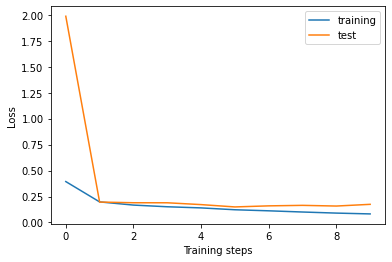

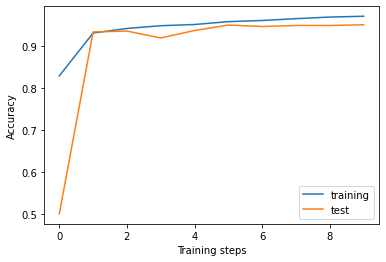

In [25]:
model.summary()

#Training visualization
#Top plot denotes losses for training and tests
#Bottom plot denotes accuracies for training and tests


plt.figure()
line1, = plt.plot(history.history['loss'])
line2, = plt.plot(history.history['val_loss'])
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2), ("training", "test"))
plt.show()

plt.figure()
line1, = plt.plot(history.history['BinAccuracy'])
line2, = plt.plot(history.history['val_BinAccuracy'])
plt.legend((line1, line2), ("training", "test"))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()